In [146]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))

In [151]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import pickle
import torch
from sklearn.metrics import auc

from matplotlib import rcParams
rcParams.update({'font.size': 16})

pd.options.display.float_format = '{:.2f}'.format

# rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 18})
# rc('text', usetex=True)

np.random.seed(42)

# Globals

In [3]:
# Load image and mask data
with open("/hdd0/projects/regex/evals/images_and_masks.pkl", 'rb') as f:
    images_and_masks = pickle.load(f)
methods = ["IoU (q=0.1)", "IoU (q=0.05)", "IoU (q=0.025)", "mAP"]   
mri_modality = 2

# Table

In [4]:
results_file = f"/hdd0/projects/regex/evals/segmentation_results_level=1.pkl"
with open(results_file, 'rb') as f:
    results_dict = pickle.load(f)
results1 = pd.DataFrame(results_dict, index=methods)
# results1.pop("Solver Attention")
results1*100

,GradCAM,InputXGradients,DeepLIFT,LRP,Baseline Attention,Solver Attention,Marginal Attention
IoU (q=0.1),43.81,15.00,13.69,15.00,29.34,NaN,32.51
IoU (q=0.05),53.57,22.34,19.57,22.34,31.18,NaN,36.11
IoU (q=0.025),44.07,25.00,23.03,25.00,24.12,NaN,26.67
mAP,73.83,34.09,32.09,34.09,45.50,NaN,49.08


In [5]:
results_file = f"/hdd0/projects/regex/evals/segmentation_results_level=2.pkl"
with open(results_file, 'rb') as f:
    results_dict = pickle.load(f)
results2 = pd.DataFrame(results_dict, index=methods) * 100
results2
# results2.pop("Solver Attention")

,GradCAM,InputXGradients,DeepLIFT,LRP,Baseline Attention,Solver Attention,Marginal Attention
IoU (q=0.1),40.52,15.10,16.67,15.10,38.83,NaN,38.30
IoU (q=0.05),57.41,22.67,23.51,22.67,50.17,NaN,48.18
IoU (q=0.025),51.14,25.66,26.29,25.66,40.78,NaN,38.74
mAP,85.20,35.33,37.56,35.33,71.34,NaN,68.03


In [6]:
results_file = f"/hdd0/projects/regex/evals/segmentation_results_level=3.pkl"
with open(results_file, 'rb') as f:
    results_dict = pickle.load(f)
results3 = pd.DataFrame(results_dict, index=methods) * 100
results3

,GradCAM,InputXGradients,DeepLIFT,LRP,Baseline Attention,Solver Attention,Marginal Attention
IoU (q=0.1),35.95,15.13,18.22,15.13,17.11,32.59,41.41
IoU (q=0.05),49.07,22.88,26.22,22.88,16.76,40.53,52.46
IoU (q=0.025),46.58,26.72,29.33,26.72,13.63,34.12,46.07
mAP,74.60,37.18,42.50,37.18,16.61,58.93,78.31


In [7]:
results_file = f"/hdd0/projects/regex/evals/segmentation_results_level=4.pkl"
with open(results_file, 'rb') as f:
    results_dict = pickle.load(f)
results4 = pd.DataFrame(results_dict, index=methods) * 100
results4
# results2.pop("Solver Attention")

,GradCAM,InputXGradients,DeepLIFT,LRP,Baseline Attention,Solver Attention,Marginal Attention
IoU (q=0.1),11.33,15.55,20.39,15.55,36.24,NaN,36.56
IoU (q=0.05),18.23,23.61,29.98,23.61,42.81,NaN,48.65
IoU (q=0.025),25.95,28.12,32.95,28.12,36.09,NaN,43.15
mAP,31.76,39.21,47.95,39.21,66.03,NaN,74.85


## Level 3 segmentation

In [8]:
results3.transpose()

,IoU (q=0.1),IoU (q=0.05),IoU (q=0.025),mAP
GradCAM,35.95,49.07,46.58,74.60
InputXGradients,15.13,22.88,26.72,37.18
DeepLIFT,18.22,26.22,29.33,42.50
LRP,15.13,22.88,26.72,37.18
Baseline Attention,17.11,16.76,13.63,16.61
Solver Attention,32.59,40.53,34.12,58.93
Marginal Attention,41.41,52.46,46.07,78.31


In [9]:
print(results3.to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  GradCAM &  InputXGradients &  DeepLIFT &   LRP &  Baseline Attention &  Solver Attention &  Marginal Attention \\
\midrule
IoU (q=0.1)   &    35.95 &            15.13 &     18.22 & 15.13 &               17.11 &             32.59 &               41.41 \\
IoU (q=0.05)  &    49.07 &            22.88 &     26.22 & 22.88 &               16.76 &             40.53 &               52.46 \\
IoU (q=0.025) &    46.58 &            26.72 &     29.33 & 26.72 &               13.63 &             34.12 &               46.07 \\
mAP           &    74.60 &            37.18 &     42.50 & 37.18 &               16.61 &             58.93 &               78.31 \\
\bottomrule
\end{tabular}



In [10]:
results_file = f"/hdd0/projects/regex/evals/segmentation_results_level=4.pkl"
with open(results_file, 'rb') as f:
    results_dict = pickle.load(f)
results4 = pd.DataFrame(results_dict, index=methods) * 100

## Level 4 segmentation

In [11]:
results4

,GradCAM,InputXGradients,DeepLIFT,LRP,Baseline Attention,Solver Attention,Marginal Attention
IoU (q=0.1),11.33,15.55,20.39,15.55,36.24,NaN,36.56
IoU (q=0.05),18.23,23.61,29.98,23.61,42.81,NaN,48.65
IoU (q=0.025),25.95,28.12,32.95,28.12,36.09,NaN,43.15
mAP,31.76,39.21,47.95,39.21,66.03,NaN,74.85


In [12]:
print(results4.to_latex())

\begin{tabular}{lrrrrrlr}
\toprule
{} &  GradCAM &  InputXGradients &  DeepLIFT &   LRP &  Baseline Attention & Solver Attention &  Marginal Attention \\
\midrule
IoU (q=0.1)   &    11.33 &            15.55 &     20.39 & 15.55 &               36.24 &              NaN &               36.56 \\
IoU (q=0.05)  &    18.23 &            23.61 &     29.98 & 23.61 &               42.81 &              NaN &               48.65 \\
IoU (q=0.025) &    25.95 &            28.12 &     32.95 & 28.12 &               36.09 &              NaN &               43.15 \\
mAP           &    31.76 &            39.21 &     47.95 & 39.21 &               66.03 &              NaN &               74.85 \\
\bottomrule
\end{tabular}



In [13]:
pd.MultiIndex.from_frame(results4)

MultiIndex([(11.330933988097739, 15.552943601779177, 20.392698359956807, ...),
            (18.234379417574516,  23.61326760887862, 29.980217578497857, ...),
            ( 25.95239315148619, 28.116972887996607,  32.94651971367122, ...),
            (31.755127198636895,  39.20930917639272,   47.9463297775212, ...)],
           names=['GradCAM', 'InputXGradients', 'DeepLIFT', 'LRP', 'Baseline Attention', 'Solver Attention', 'Marginal Attention'])

# Images with heatmaps

In [284]:
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize
from torchvision.transforms import InterpolationMode
from kornia.augmentation import Normalize
from dataio.dataloader import probe_data_folder, BraTS18Binary
    
# Load attribution data
level = 3
method_names = [
    ("GradCAM", f'gc_attrs_level=3.pkl', f'gc_attrs_level=4.pkl'),
#     ("Gradient*Input", f'inxgrad_attrs_level=3.pkl', f'inxgrad_attrs_level=4.pkl'), 
    ("DeepLIFT", f'dl_attrs_level=3.pkl', f'dl_attrs_level=4.pkl'), 
#     ("LRP", f'lrp_attrs_level=3.pkl', f'lrp_attrs_level=4.pkl'), 
    ("Baseline", f'baseline_attrs_level=3.pkl', f'baseline_attrs_level=4.pkl'), 
#     ("Solver", f'solver_attrs_level=3.pkl', f'solver_attrs_level=4.pkl'),
    ("Marginal", f'marginal_attrs_level=3.pkl', f'marginal_attrs_level=4.pkl')
]

methods = []
for name, filename3, filename4 in method_names:
    with open(f"../evals/{filename3}", 'rb') as f:
        file3 = pickle.load(f)
    with open(f"../evals/{filename4}", 'rb') as f:
        file4 = pickle.load(f)
    methods.append((name, file3, file4))
# results.pop("Solver Attention")

In [296]:
samples = np.random.randint(0, high=len(images_and_masks), size=1)
# samples = [1899, 1297, 2062, 1955, 870, 161, 502, 763, 1367, 2088]

<ipython-input-297-da586e310be5>:39: UserWarning: No contour levels were found within the data range.
  mri_ax.contour(np.arange(mask.shape[0]), np.arange(mask.shape[1]), mask, 0, linewidths=2, colors=["red"])


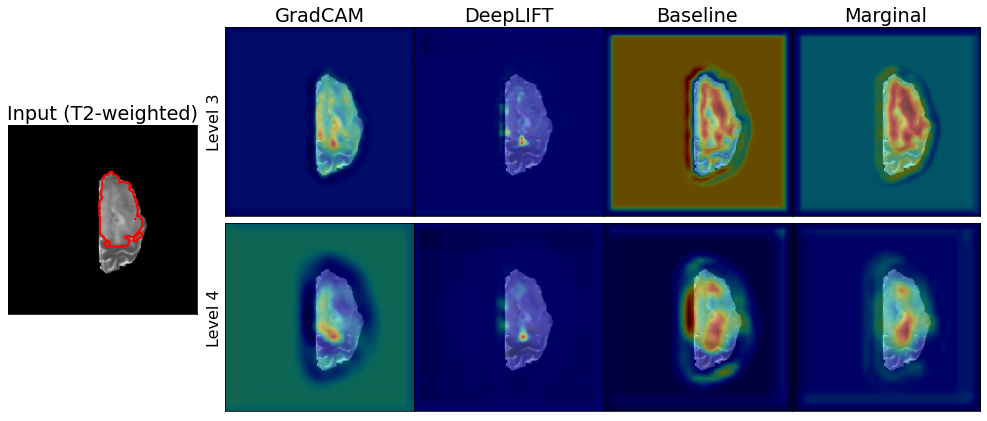

In [297]:
fig = plt.figure(figsize=(3*(len(methods)+1), 2*3*len(samples)))
gs = gridspec.GridSpec(nrows=2*len(samples), 
                       ncols=len(methods)+1+1, 
                       left=0.05, 
                       bottom=0.05, 
                       right=0.95, 
                       top=0.95, 
                       wspace=0.0, 
                       hspace=0.01,
                       width_ratios=[1,0.15,1,1,1,1])

# Set mri image col
mri_col = []
i = 0
for _ in range(len(samples)):
    ax = plt.subplot(gs[i:i+2, 0])
    mri_col.append(ax)
    i += 2

# Set blank image col
blank_col = []
for i in range(2*len(samples)):
    ax = plt.subplot(gs[i, 1])
    blank_col.append(ax)
    
# Set attributions matrix
matrix = []
for i in range(2*len(samples)):
    row = []
    for j in range(len(methods)):
        ax = plt.subplot(gs[i, j+2])
        row.append(ax)
    matrix.append(row)

# Plot mri images
for mri_ax, sample_idx in zip(mri_col, samples):
    image, label, mask = images_and_masks[sample_idx]
    mri_ax.imshow(image[mri_modality], cmap="gray")
    mri_ax.contour(np.arange(mask.shape[0]), np.arange(mask.shape[1]), mask, 0, linewidths=2, colors=["red"])

# Plot attribution
running_idx = 0
for i in range(0, 2*len(samples), 2):
    idx = samples[running_idx]
    image, label, mask = images_and_masks[idx]
    for j in range(len(methods)):
        attr3 = methods[j][1][idx][0]
        attr3 = cv2.resize(attr3.numpy(), (256, 256), interpolation=cv2.INTER_LINEAR)
        attr4 = methods[j][2][idx][0]
        attr4 = cv2.resize(attr4.numpy(), (256, 256), interpolation=cv2.INTER_LINEAR)
        matrix[i][j].imshow(image[mri_modality], cmap="gray")
        matrix[i][j].imshow(attr3, cmap="jet", alpha=0.4)
        matrix[i+1][j].imshow(image[mri_modality], cmap="gray")
        matrix[i+1][j].imshow(attr4, cmap="jet", alpha=0.4)
    running_idx += 1

# Set titles
mri_col[0].set_title(f"Input (T2-weighted)")
for j, ax in enumerate(matrix[0]):
    ax.set_title(methods[j][0])
    
for i, row in enumerate(matrix):
    if i % 2 == 0:
        row[0].set_ylabel("Level 3", labelpad=0.0)
    else:
        row[0].set_ylabel("Level 4", labelpad=0.0)
        
for ax in mri_col:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='both', which='both', length=0)
    
for ax in blank_col:
    ax.axis("off")
    
for row in matrix:
    for ax in row:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(axis='both', which='both', length=0)